# Horizonts detection model

## Content

* [Problem description](description)
* [Dataset](dataset)
* [Model architecture](architecture)
* [Training](training)
* [Validation](validation)
* [Criticism](criticism)
* [Conclusion](conclusion)
* [Suggestions for improvements](suggestions)


<a id='description'></a>

# Problem description

Seismic horizon is a change in rock properties across a boundary between two layers of rock, particularly seismic velocity and density. Such changes are visible in seismic images (even for an untrained eye), and could be automatically detected: 

<img src="images/unlabeled_slide.png" alt="Drawing" style="width: 400px; height: 400px"/>

This notebook demonstrates how to build convolutional neural network that detects all of the horizonts on the given cube.

<a id='dataset'></a>

# Dataset

We use multiple seismic cubes, in particular, `Cube 1`, `Cube 3` and `Cube VU_ONGMK`, for training. `Cube 2` is reserved for validation purposes. A number of hand-labelled horizonts goes along with each cube, and can be seen on image below. Detailed description of each cube, including more sample images, is available [here](./../datasets/Horizonts_modelling.ipynb).

<img src="images/labeled_slide.jpg" alt="Drawing" style="width: 400px; height: 400px"/>

Importantly, each cube is too big to fit into the GPU memory, so we must cut small crops out of it in order to train the model. This changes whole pipeline of research: we need convenient methods of:
* splitting seismic cubes into crops of desired shape
* lazy loading crops into memory (with quite hard memory constraints)
* training model on labeled crops
* predicting with trained model on unlabeled crops
* assemble predictions back into the whole cube

`Seismiqb` package provides exactly this. Some examples of ready-to-use pipelines can be found [here.](./../tutorials/2.%20Batch.ipynb)

**Note:** we heavily rely on [BatchFlow](https://github.com/analysiscenter/batchflow) to define sophisticated neural network architectures with just a few lines of code.

In [10]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
import logging
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

sys.path.append('..')
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R
from seismiqb.batchflow.models.tf import *
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset
from seismiqb import plot_loss
from utils import *

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set GPU
%env CUDA_VISIBLE_DEVICES=0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=0


First of all, we index `.hdf5` cubes with the help of [FilesIndex](https://analysiscenter.github.io/batchflow/intro/dsindex.html). `SeismicCubeset` provides lots of processing actions for different types of seismic information (cubes in different formats, labels).

In [2]:
paths_cubes = ['/notebooks/SEISMIC_DATA/CUBE_1/E_anon.hdf5',
               '/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5',
               '/notebooks/SEISMIC_DATA/CUBE_VUONGMK/Repaired_cube.hdf5']

dsi = FilesIndex(path=paths_cubes, no_ext=True)
ds = SeismicCubeset(dsi)

Now we need to get information about cube geometries, process `.txt` labels and lay out some inner structure. That is done by different `SeismicCubeset`'s methods, and is explained in great detail in [this](./../tutorials/1.%20Cubeset.ipynb) tutorial.

As we want to train model more on harder data, different proportions for cubes for sampling points from are set: we want to train not as often on Cube 3 due to its simplicity. That is done via `p` (proportions) argument.

In [3]:
%%time
ds = load(ds, p=[0.4, 0.2, 0.4])
# ~80 seconds

CPU times: user 1min 8s, sys: 17.9 s, total: 1min 26s
Wall time: 1min 32s


Despite the fact that we have a whole cube (namely, `Cube 2`) for validation purposes, we would like to hold out  20% of each cube in the train dataset. That can be easily achieved with `modify_sampler` method:

In [4]:
ds.modify_sampler('train_sampler', low=0.0, high=0.8, finish=True)
ds.modify_sampler('test_sampler',  low=0.8, high=1.0, finish=True)

That creates two attributes, `ds.train_sampler` and `ds.test_sampler`, which are used to sample crops from the first 80% of ilines or the last 20% of ilines respectively. That is also shown in [tutorial](./../tutorials/1.%20Cubeset.ipynb).

<a id='architecture'></a>

# Model architecture

We use convonlutional neural network in `EncoderDecoder` fashion and train on crops of (256, 256, 2) size:
* First of all, initial crop is downsampled twice along xlines/heights dimensions, effectively reducing resolution 4 times
* Then, we encode crop by applying `inception_a_block` of Inception_v4 3 times with max-pooling in-between
* `Inception_c_block` is applied at the bottleneck
* Initial shape of the block is restored by transposed convolutions with ordinary convolutions+batchnorm+activation(ReLU) in-between

Multiple things are worth noting. Most importantly, model percieves every crop (a 3-d entity) as sequence of 2-d images stacked one after the other, and every convolution that is used is 2D.
Every max-pooling in the network is of size and stride 2, effectively halving the resolution of its inputs. To get precise definitions of `Inception` blocks, check [this](https://arxiv.org/pdf/1602.07261.pdf) paper.

Technical note: in order to compute `Dice`-coefficient, we need to add axis both to the output of neural network and to initial labels. That is done via `predictions` callable in the first case and `add_axis` action in the second.

In [5]:
# Global constants
EPOCHS = 15
NUM_CROPS = 64
CROP_SHAPE = (2, 256, 256) # i, x, h

In [6]:
# Custom ED class is to ensure that `head` block does not `crop` its inputs.
# For more on that, check the `head` method of EncoderDecoder
class ED(EncoderDecoder):
    @classmethod
    def head(cls, inputs, targets, name='head', **kwargs):
        kwargs = cls.fill_params('head', **kwargs)
        with tf.variable_scope(name):
            channels = cls.num_channels(targets)
            x = conv_block(inputs, filters=channels, **kwargs)
            x = tf.expand_dims(x, axis=-1, name='expand')
        return x


# Model configuration
model_config = {
    # Shapes and orders
    'inputs/cubes/shape': (None, None, CROP_SHAPE[0]),
    'inputs/masks/shape': (None, None, CROP_SHAPE[0], 1), 
    'initial_block/inputs': 'cubes',
    'common': {'data_format': 'channels_last'},
    # Model layout
    'initial_block': {'layout': 'pp'},
    'body/encoder': {'num_stages': 3,
                     'blocks': {'base': Inception_v4.inception_a_block,
                                'filters': [[32, 16], [48, 32], [64, 48]]}},
    'body/embedding': {'base': Inception_v4.inception_c_block,
                       'filters': [32, 48, 64, 96]},
    'body/decoder': {'num_stages': 5,
                     'blocks': {'layout':'cna',
                                'filters': [32, 16, 8, 6, 4]}},
    'output': 'sigmoid',
    # Train configuration
    'loss': 'dice',
    'optimizer': 'Adam',
    'decay': {'name': 'invtime',
              'learning_rate': 0.01,
              'decay_rate': 1,
              'decay_steps': 100},
    'microbatch': 4,
}

pipeline_config = {
    'model': ED,
    'model_config': model_config,
}

<a id='training'></a>

# Training

Neural network is trained on crops of fixed shape. Pipeline consists of following steps:
* First of all, we initialize all the pipeline variables, that we need, and the model itself
* Then, we create positions of crops, then load actual data and labels for it. Data is immediately scaled to $[0, 1]$ range in order to normalize values from different cubes
* Right after, multiple augmentations are applied to simulate different distortions and make model robust to them
* Model weights update

In [7]:
train_pipeline = (Pipeline(config=pipeline_config)
                  # Initialize pipeline variables and model
                  .init_variable('current_loss')
                  .init_variable('loss_history', [])
                  .init_model('dynamic', C('model'), 'ED', C('model_config'))
                  # Load data/masks
                  .load_component(src=[D('geometries'), D('labels')],
                                  dst=['geometries', 'labels'])
                  .crop(points=L(D('train_sampler'), NUM_CROPS),
                        shape=CROP_SHAPE)
                  .load_cubes(dst='data_crops')
                  .create_masks(dst='mask_crops', width=2)
                  .rotate_axes(src=['data_crops', 'mask_crops'])
                  .scale(mode='normalize', src='data_crops')
                  # Augmentations
                  .additive_noise(scale=0.005,
                                  src='data_crops', dst='data_crops', p=0.2)
                  .rotate(angle=P(R('uniform', -30, 30)),
                          src=['data_crops', 'mask_crops'], p=0.4)
                  .scale_2d(scale=P(R('uniform', 0.7, 1.3)),
                            src=['data_crops', 'mask_crops'], p=0.4)
                  .cutout_2d(patch_shape=P(R('uniform', 10, 30, size=2)), n=P(R('uniform', 3, 17)),
                             src='data_crops', p=0.2)
                  .elastic_transform(alpha=P(R('uniform', 35, 45)), sigma=P(R('uniform', 4, 4.5)),
                                     src=['data_crops', 'mask_crops'], p=0.2)
                  # Training
                  .add_axis(src='mask_crops', dst='mask_crops')
                  .train_model('ED', 
                               fetches='loss',
                               cubes=B('data_crops'),
                               masks=B('mask_crops'),
                               save_to=V('current_loss'))
                  .update_variable('loss_history', 
                                   V('current_loss'), 
                                   mode='a')) << ds

Every batch contains 64 crops of (256, 256, 2) size. Model is trained for 1500 epochs by `Adam` optimizer with default parameters, [inverse-time learning rate decay](https://www.tensorflow.org/api_docs/python/tf/train/inverse_time_decay).

In [8]:
# Training loop. Allows to see progress (value of loss)
with tqdm(total=EPOCHS) as pbar:
    for e in range(1, EPOCHS+1):
        train_batch = train_pipeline.next_batch(3, n_epochs=None)

        current_loss = train_pipeline.get_variable("current_loss")
        pbar.set_description('Loss:{:12.7}'.format(current_loss))
        pbar.update(1)

Loss:  -0.2187347: 100%|██████████| 15/15 [02:06<00:00,  4.84s/it]


Loss against iterations:

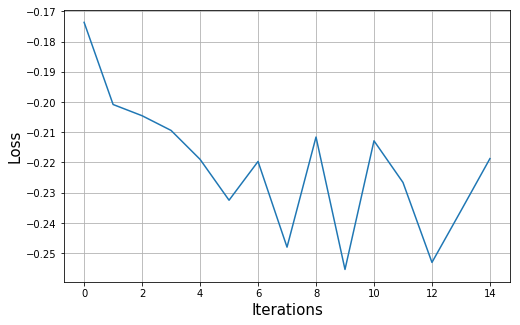

In [11]:
plot_loss(train_pipeline.v('loss_history'))

As we can see, loss starts to plateau after just 90 minutes of training. Relatively high variance suggests that model can benefit from bigger batch size.

<a id='validation'></a>

# Validation

Now, we want to check performance of our model on unseen part of the cubes. 

In [12]:
val_pipeline = (Pipeline()
                # Import model
                .import_model('ED', train_pipeline)
                # Load data/masks
                .load_component(src=[D('geometries'), D('labels')],
                                dst=['geometries', 'labels'])
                .crop(points=L(D('test_sampler'), NUM_CROPS), shape=CROP_SHAPE)
                .load_cubes(dst='data_crops')
                .create_masks(dst='mask_crops')
                .rotate_axes(src=['data_crops', 'mask_crops'])
                .scale(mode='normalize', src='data_crops')
                # Predict with model
                .add_axis(src='mask_crops', dst='mask_crops')
                .predict_model('ED', 
                               fetches='predictions',
                               cubes=B('data_crops'),
                               save_to=B('predictions'))
                ) << ds

val_batch = val_pipeline.next_batch(3, n_epochs=None)

We can just plot images of crops, hand-labeled masks and model predictions:

Images from E_anon


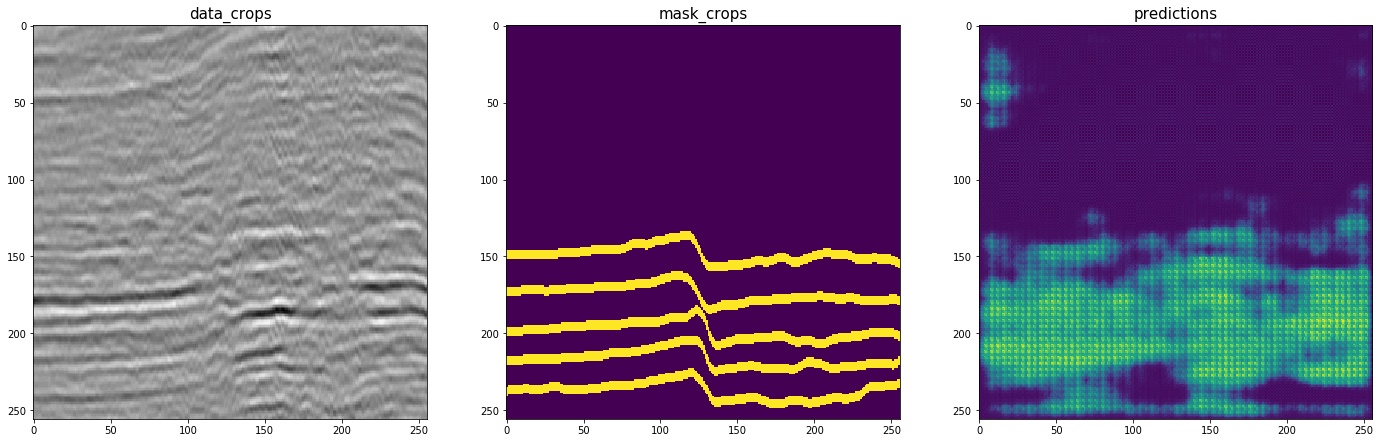

In [13]:
val_batch.plot_components(13, False, 'data_crops', 'mask_crops', 'predictions')

It is time to save the model:

In [14]:
model_save_dir = '/notebooks/SEISMIC_DATA/SAVED/MODELS/ED_DEMO'
train_pipeline.save_model_now('ED', model_save_dir)

It is way easier to analyse results when multiple crops are aggregated back into bigger picture. Method `make_grid`, paired with action `assemble_crops`, does exactly that:

In [15]:
%%time
load_config = {'load/path': model_save_dir}

ds = ds.make_grid(ds.indices[0], CROP_SHAPE, 
                  [2201, 2202], [0, 800], [100, 1300],
                  strides=[1, 128, 128])

pred_pipeline = (Pipeline()
                 # Initialize everything
                 .init_variable('result_cubes', init_on_each_run=list())
                 .init_variable('result_preds', init_on_each_run=list())
                 .init_model('dynamic', TFModel, 'loaded_model', load_config)              
                 # Load data
                 .load_component(src=D('geometries'), dst='geometries')
                 .crop(points=L(D('grid_gen')),
                       shape=CROP_SHAPE)
                 .load_cubes(dst='data_crops')
                 .rotate_axes(src='data_crops')
                 .scale(mode='normalize', src='data_crops')
                 # Predict with model, then aggregate
                 .predict_model('loaded_model', 
                                fetches=['cubes', 'predictions'],
                                cubes=B('data_crops'),
                                save_to=[V('result_cubes', mode='e'),
                                         V('result_preds', mode='e')])
                 .assemble_crops(src=V('result_preds'), dst='assembled_pred',
                                   grid_info=D('grid_info'))
                 .assemble_crops(src=V('result_cubes'), dst='assembled_cube',
                                   grid_info=D('grid_info'))
                 ) << ds

for _ in range(ds.grid_iters):
    pred_batch = pred_pipeline.next_batch(3, n_epochs=None)

INFO:tensorflow:Restoring parameters from /notebooks/SEISMIC_DATA/SAVED/MODELS/ED_DEMO/model-15
CPU times: user 14.3 s, sys: 1.54 s, total: 15.8 s
Wall time: 16.8 s


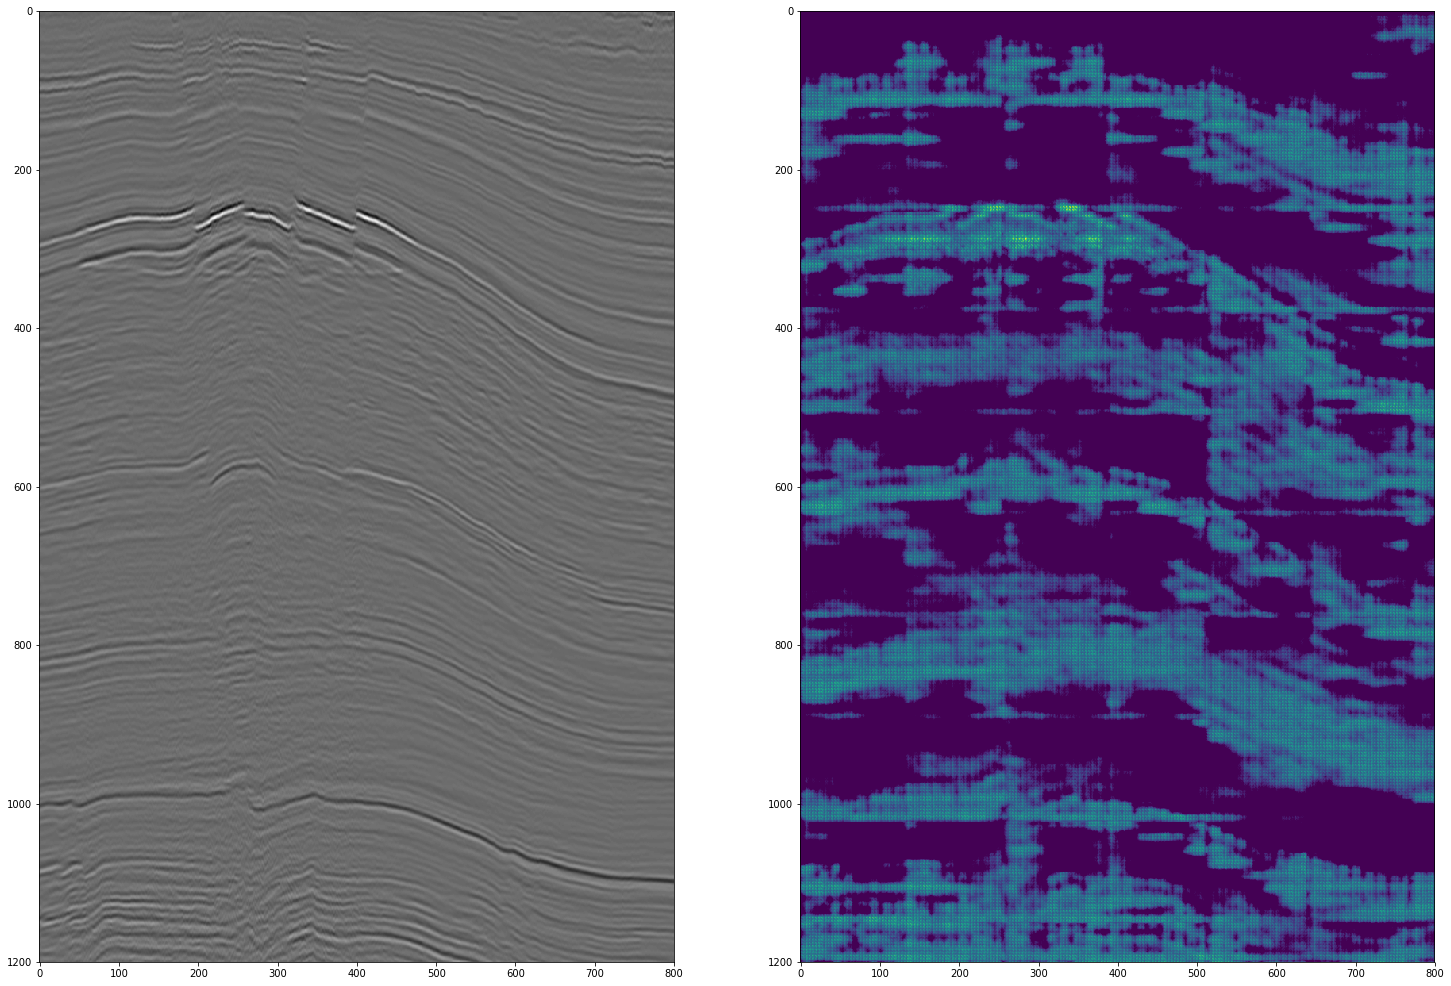

In [16]:
img_full = pred_batch.assembled_cube
pred_full = pred_batch.assembled_pred

fig, ax = plt.subplots(1, 2, figsize=(25, 25))
ax[0].imshow(img_full[0, :, :].T, cmap='gray')
ax[1].imshow(pred_full[0, :, :].T)
plt.show()

Note that `assemble_crops` takes action only once, when all of the crops are passed through the model. Also, this function can be quite memory intensive.

Due to slow changes in data along ilines in any given cube, it might be a good idea to test our model against completely new cube. To begin with, we need to load it:

In [17]:
%%time
test_path_data = '/notebooks/SEISMIC_DATA/CUBE_2/M_cube.hdf5'

test_dsi = FilesIndex(path=[test_path_data], no_ext=True)
test_ds = SeismicCubeset(test_dsi)

test_ds = load(test_ds)
## ~ 4 seconds

CPU times: user 2.77 s, sys: 256 ms, total: 3.02 s
Wall time: 3.34 s


In [18]:
%%time
load_config = {'load/path': model_save_dir}

test_ds = test_ds.make_grid(test_ds.indices[0], CROP_SHAPE, 
                            [201, 202], [0, 800], [100, 1300],
                            strides=[1, 128, 128])

pred_pipeline = (Pipeline()
                 # Initialize everything
                 .init_variable('result_cubes', init_on_each_run=list())
                 .init_variable('result_preds', init_on_each_run=list())
                 .init_model('dynamic', TFModel, 'loaded_model', load_config)              
                 # Load data
                 .load_component(src=D('geometries'), dst='geometries')
                 .crop(points=L(D('grid_gen')),
                       shape=CROP_SHAPE)
                 .load_cubes(dst='data_crops')
                 .rotate_axes(src='data_crops')
                 .scale(mode='normalize', src='data_crops')
                 # Predict with model, then aggregate
                 .predict_model('loaded_model', 
                                fetches=['cubes', 'predictions'],
                                cubes=B('data_crops'),
                                save_to=[V('result_cubes', mode='e'),
                                         V('result_preds', mode='e')])
                 .assemble_crops(src=V('result_preds'), dst='assembled_pred',
                                   grid_info=D('grid_info'))
                 .assemble_crops(src=V('result_cubes'), dst='assembled_cube',
                                   grid_info=D('grid_info'))
                 ) << test_ds

for _ in range(test_ds.grid_iters):
    pred_batch = pred_pipeline.next_batch(1, n_epochs=None)

INFO:tensorflow:Restoring parameters from /notebooks/SEISMIC_DATA/SAVED/MODELS/ED_DEMO/model-15
CPU times: user 12.3 s, sys: 1.4 s, total: 13.7 s
Wall time: 14.2 s


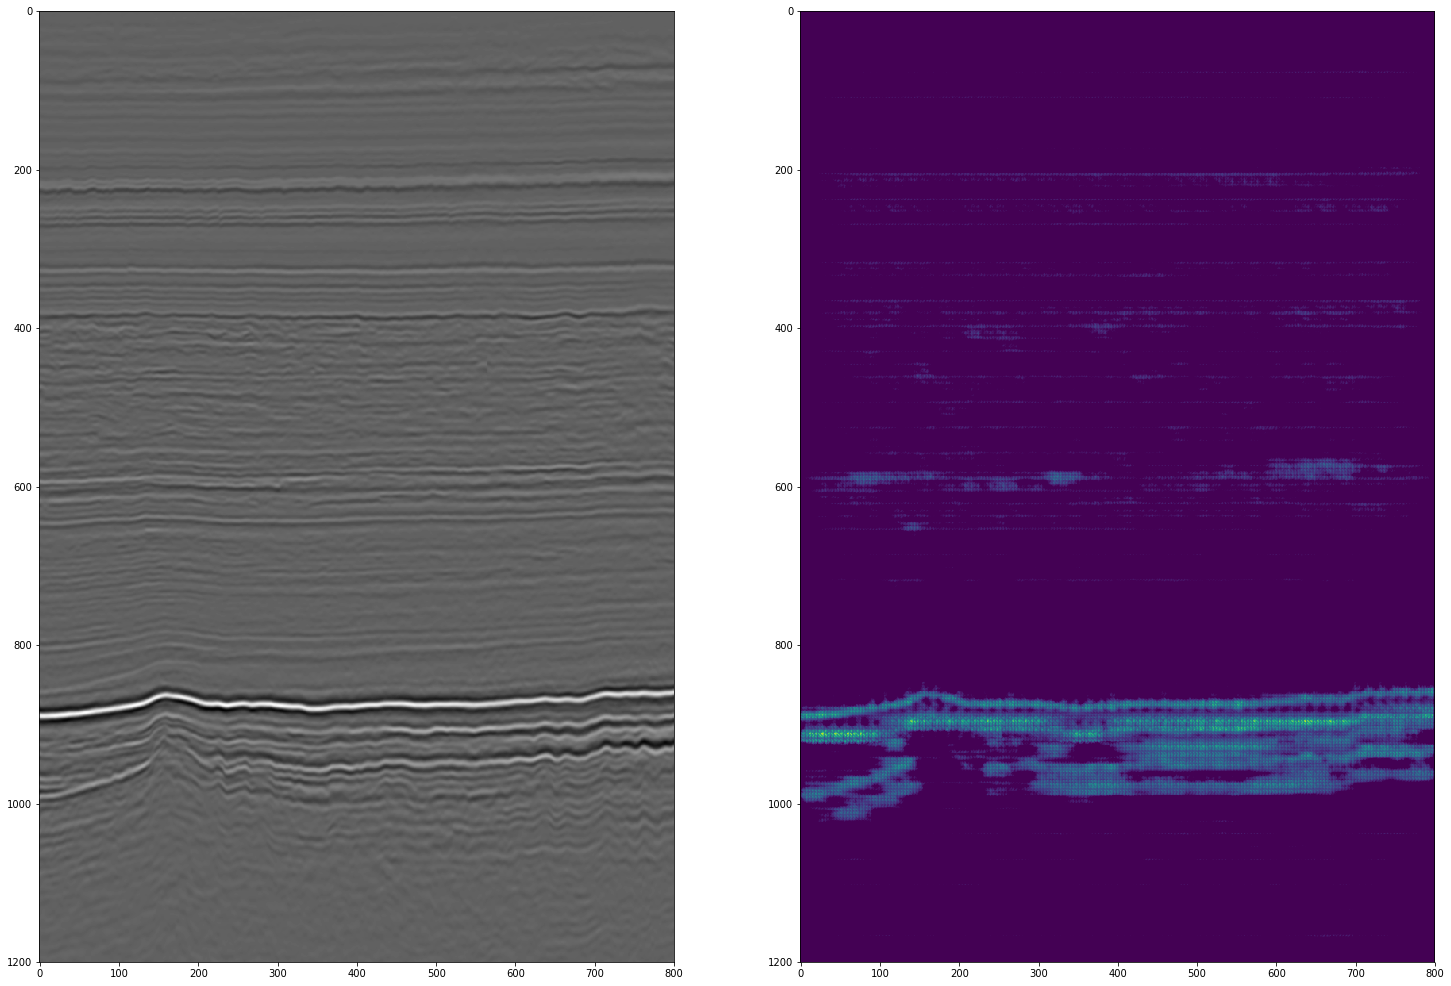

In [19]:
img_full = pred_batch.assembled_cube
pred_full = pred_batch.assembled_pred

fig, ax = plt.subplots(1, 2, figsize=(25, 25))
ax[0].imshow(img_full[0, :, :].T, cmap='gray')
ax[1].imshow(pred_full[0, :, :].T)
plt.show()

As we can see, even on completely new cube our model outputs reasonable horizonts.

In [20]:
%%time
_ = test_ds.get_point_cloud(pred_full, 'horizons', coordinates='lines', threshold=0.1)

CPU times: user 11.3 s, sys: 48 ms, total: 11.3 s
Wall time: 11.3 s


In [21]:
_ = [print(len(item)) for item in test_ds.horizons[:10]]

800
732
411
395
362
271
254
235
219
188


Mean value/std of error:                  35.79326 / 13.94646
Horizont length:                          800
Rate in 5 ms window:                           0.0
Average height/std of true horizont:      979.8577
Average height/std of predicted horizont: 1014.651
Number of values that were labeled by model and not labeled by experts: 20


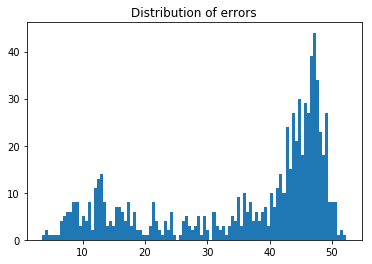

In [22]:
compare(test_ds, test_ds.horizons[0])

<a id='criticism'></a>

# Criticism

The task in hand is ill-defined: we don't know, how many horizonts (and which) we want to predict. Despite that, this model serves as a great trampoline for the others: [horizont extension](./Horizons_extension.ipynb) and [facies segmentation](./Segmenting_interlayers.ipynb).

<a id='conclusion'></a>

# Conclusion

<a id='suggestions'></a>

# Suggestions for improvements

* add non-regular grid for assemble_crops

* improve conventions inside of the assemble_grid - DONE

* make whole end-to-end pipeline of model evaluation - DONE

* make `assemble_crop` memory stable: use disk space as background

* incorporate current features into notebook: `get_point_cloud`, better model configs, new format of labels, etc